## Hospital Star Rating Analysis

## Importing libraries 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_context('paper')

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan



## Declaring utility functions

In [2]:
# Util function: line seperator
def print_ln():
    print('-' * 80, '\n')


# Function to create a subset of the dataframe
def subset(dataframe, col_name, col_names_list):
    return dataframe.loc[dataframe[col_name].isin(col_names_list)]

In [3]:
def func_numeric(df, col_name):
    df[col_name] = df[col_name].astype(float)
    return df


In [4]:
def func_rename(df):
    old_col_names = df.columns.to_list()
    new_col_names = []
    for a_col_name in old_col_names:
        col_name = a_col_name + "_score"
        new_col_names.append(col_name)

    name_pairs = dict(zip(old_col_names, new_col_names))
    df = df.rename(columns=name_pairs)
    return df


In [5]:
def negative_zscore(dataframe):
    df = dataframe.copy()
    cols = list(df.columns)
    for col in cols:
        df[col] = - (df[col] - df[col].mean())/df[col].std(ddof=0)
    return df


def positive_zscore(dataframe):
    df = dataframe.copy()
    cols = list(df.columns)
    for col in cols:
        df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    return df


In [6]:
def subset_by_iqr(df, column, whisker_width=0):
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.00125)
    q3 = df[column].quantile(0.99875)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter][column]

#df_filtered = subset_by_iqr(df, 'READM_30_STK_score')
#df_filtered

def treat_outliers(dataframe):
    df = dataframe.copy()
    cols = list(df.columns)
    for col in cols:
        df[col] = subset_by_iqr(df, col)
    return df


In [7]:
def function_group_score(numeric_df, score_name):
    df = numeric_df.dropna(thresh= 3)
    imputed_df = df.apply(lambda x: x.fillna(x.median()), axis=0)
    pca = IncrementalPCA()
    df_pca = pca.fit_transform(imputed_df)
    df_pca = pd.DataFrame(df_pca, columns= df.columns)
    df_pca.index = df.index
    df_with_weight = df_pca.mean(axis=1)
    df_scores = pd.DataFrame({score_name : df_with_weight})
    return df_scores



## Data cleaning and preliminary exploration

In [8]:

read_rawdata = pd.read_csv("Readmissions and Deaths - Hospital.csv",
                           encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])

read_rawdata.shape


(67452, 18)

In [9]:
read_rawdata.head(10)


,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Compared to National,Denominator,Score,Lower Estimate,Higher Estimate,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Morta...,MORT_30_AMI,No Different than the National Rate,733.0,12.5,10.6,14.9,NaN,07/01/2012,06/30/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for CABG,MORT_30_CABG,No Different than the National Rate,278.0,4.2,2.6,6.8,NaN,07/01/2012,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for chronic obstructive pulmonary d...,MORT_30_COPD,No Different than the National Rate,586.0,9.3,7.3,11.8,NaN,07/01/2012,06/30/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart failure (HF) 30-Day Mortality Rate,MORT_30_HF,No Different than the National Rate,797.0,12.4,10.4,14.6,NaN,07/01/2012,06/30/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Pneumonia (PN) 30-Day Mortality Rate,MORT_30_PN,No Different than the National Rate,599.0,15.5,13.0,18.5,NaN,07/01/2012,06/30/2015
5,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for stroke patients,MORT_30_STK,No Different than the National Rate,512.0,15.4,12.8,18.6,NaN,07/01/2012,06/30/2015
6,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Readm...,READM_30_AMI,No Different than the National Rate,781.0,16.5,14.6,18.8,NaN,07/01/2012,06/30/2015
7,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Rate of readmission for CABG,READM_30_CABG,No Different than the National Rate,273.0,15.1,12.3,18.5,NaN,07/01/2012,06/30/2015
8,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Rate of readmission for chronic obstructive pu...,READM_30_COPD,No Different than the National Rate,707.0,21.1,18.7,23.8,NaN,07/01/2012,06/30/2015
9,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart failure (HF) 30-Day Readmission Rate,READM_30_HF,No Different than the National Rate,981.0,21.4,19.2,23.7,NaN,07/01/2012,06/30/2015


In [10]:
read_rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67452 entries, 0 to 67451
Data columns (total 18 columns):
Provider ID             67452 non-null int64
Hospital Name           67452 non-null object
Address                 67452 non-null object
City                    67452 non-null object
State                   67452 non-null object
ZIP Code                67452 non-null int64
County Name             67242 non-null object
Phone Number            67452 non-null int64
Measure Name            67452 non-null object
Measure ID              67452 non-null object
Compared to National    52902 non-null object
Denominator             41710 non-null float64
Score                   41710 non-null float64
Lower Estimate          41710 non-null float64
Higher Estimate         41710 non-null float64
Footnote                25742 non-null object
Measure Start Date      67452 non-null object
Measure End Date        67452 non-null object
dtypes: float64(4), int64(3), object(11)
memory usage: 9.3+ MB

## Declaring the list of important measures associated with a particular group

In [14]:
read_meas_list =   ["READM_30_AMI", "READM_30_CABG", "READM_30_COPD", "READM_30_HF", "READM_30_HIP_KNEE", "READM_30_HOSP_WIDE", "READM_30_PN", "READM_30_STK"]
read_meas_list

['READM_30_AMI',
 'READM_30_CABG',
 'READM_30_COPD',
 'READM_30_HF',
 'READM_30_HIP_KNEE',
 'READM_30_HOSP_WIDE',
 'READM_30_PN',
 'READM_30_STK']

In [15]:
read_hosp = read_rawdata.iloc[:,0:8]
read_hosp.head(5)

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701


In [16]:
read_hosp = read_hosp.drop_duplicates(keep='first')
read_hosp

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701
14,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310
28,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400
42,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541
56,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374
70,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122
84,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150
98,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100
112,10018,CALLAHAN EYE HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100
126,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,COLBERT,2563864556


In [17]:
read_meas = read_rawdata.iloc[: , [0,9,12]]
read_meas

print_ln()
read_meas.info()

print_ln()
read_meas.dtypes

-------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67452 entries, 0 to 67451
Data columns (total 3 columns):
Provider ID    67452 non-null int64
Measure ID     67452 non-null object
Score          41710 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.5+ MB
-------------------------------------------------------------------------------- 



Provider ID      int64
Measure ID      object
Score          float64
dtype: object

In [18]:
# converting the datatype of Score to a float

read_meas['Score'] = read_meas['Score'].astype(float)

read_meas.dtypes

print_ln()
read_meas

-------------------------------------------------------------------------------- 



,Provider ID,Measure ID,Score
0,10001,MORT_30_AMI,12.5
1,10001,MORT_30_CABG,4.2
2,10001,MORT_30_COPD,9.3
3,10001,MORT_30_HF,12.4
4,10001,MORT_30_PN,15.5
5,10001,MORT_30_STK,15.4
6,10001,READM_30_AMI,16.5
7,10001,READM_30_CABG,15.1
8,10001,READM_30_COPD,21.1
9,10001,READM_30_HF,21.4


In [14]:
read_meas = read_meas.loc[read_meas['Measure ID'].isin(read_meas_list)]
read_meas

,Provider ID,Measure ID,Score
6,10001,READM_30_AMI,16.5
7,10001,READM_30_CABG,15.1
8,10001,READM_30_COPD,21.1
9,10001,READM_30_HF,21.4
10,10001,READM_30_HIP_KNEE,5.1
11,10001,READM_30_HOSP_WIDE,15.4
12,10001,READM_30_PN,18.7
13,10001,READM_30_STK,12.7
20,10005,READM_30_AMI,16.7
21,10005,READM_30_CABG,NaN


In [19]:
read_meas_score = read_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
print_ln()
print(read_meas_score.columns)
print_ln()
print(read_meas_score)
print_ln()
print(read_meas_score.dtypes)
print_ln()
print(read_meas_score.info())

-------------------------------------------------------------------------------- 

Index(['MORT_30_AMI', 'MORT_30_CABG', 'MORT_30_COPD', 'MORT_30_HF',
       'MORT_30_PN', 'MORT_30_STK', 'READM_30_AMI', 'READM_30_CABG',
       'READM_30_COPD', 'READM_30_HF', 'READM_30_HIP_KNEE',
       'READM_30_HOSP_WIDE', 'READM_30_PN', 'READM_30_STK'],
      dtype='object', name='Measure ID')
-------------------------------------------------------------------------------- 

Measure ID   MORT_30_AMI  MORT_30_CABG  MORT_30_COPD  MORT_30_HF  MORT_30_PN  \
Provider ID                                                                    
10001               12.5           4.2           9.3        12.4        15.5   
10005               16.0           NaN           7.6        15.5        20.8   
10006               16.7           4.1           7.1        15.6        18.2   
10007                NaN           NaN           9.3        14.4        18.8   
10008                NaN           NaN           8.2   

In [20]:
read_meas_score =  func_rename(read_meas_score)
read_meas_score



Measure ID,MORT_30_AMI_score,MORT_30_CABG_score,MORT_30_COPD_score,MORT_30_HF_score,MORT_30_PN_score,MORT_30_STK_score,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score
Provider ID,,,,,,,,,,,,,,
10001,12.5,4.2,9.3,12.4,15.5,15.4,16.5,15.1,21.1,21.4,5.1,15.4,18.7,12.7
10005,16.0,NaN,7.6,15.5,20.8,15.5,16.7,NaN,18.0,21.9,5.7,14.9,16.4,13.4
10006,16.7,4.1,7.1,15.6,18.2,17.9,16.1,15.2,19.8,20.6,5.0,15.4,17.9,12.0
10007,NaN,NaN,9.3,14.4,18.8,16.6,NaN,NaN,19.9,21.1,NaN,16.6,17.3,12.7
10008,NaN,NaN,8.2,12.7,15.7,NaN,NaN,NaN,19.2,23.1,NaN,15.7,16.0,NaN
10011,13.9,3.7,7.4,13.8,17.9,12.6,17.7,15.0,19.6,19.8,5.1,15.3,16.7,11.3
10012,16.8,NaN,9.2,12.5,26.8,15.8,16.1,NaN,19.2,23.4,NaN,15.3,19.4,12.8
10016,14.7,3.6,8.1,14.0,16.1,15.8,17.7,15.8,17.9,21.5,5.0,14.7,17.1,12.4
10018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
np.nansum(read_meas_score['READM_30_AMI_score'].unique())


1104.3

In [21]:
readmission = negative_zscore(read_meas_score)
print_ln()
readmission


-------------------------------------------------------------------------------- 



Measure ID,MORT_30_AMI_score,MORT_30_CABG_score,MORT_30_COPD_score,MORT_30_HF_score,MORT_30_PN_score,MORT_30_STK_score,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score
Provider ID,,,,,,,,,,,,,,
10001,1.249515,-0.996059,-1.094132,-0.165556,0.427705,-0.282062,0.408730,-0.615156,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569
10005,-1.546065,NaN,0.434008,-2.286446,-2.103663,-0.342167,0.199974,NaN,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118
10006,-2.105181,-0.881358,0.883461,-2.354862,-0.861860,-1.784684,0.826243,-0.703937,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980
10007,NaN,NaN,-1.094132,-1.533872,-1.148430,-1.003320,NaN,NaN,0.078174,0.570805,NaN,-1.237171,-0.130886,-0.124569
10008,NaN,NaN,-0.105335,-0.370803,0.332182,NaN,NaN,NaN,0.629471,-0.765075,NaN,-0.147737,0.774096,NaN
10011,0.131283,-0.422557,0.613789,-1.123377,-0.718575,1.400875,-0.843809,-0.526375,0.314444,1.439128,-0.884170,0.336456,0.286798,1.180529
10012,-2.185055,NaN,-1.004242,-0.233972,-4.969363,-0.522481,0.826243,NaN,0.629471,-0.965457,NaN,0.336456,-1.592780,-0.217790
10016,-0.507707,-0.307857,-0.015445,-1.260209,0.141135,-0.522481,-0.843809,-1.236623,1.653308,0.303629,-0.703459,1.062745,0.008342,0.155095
10018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:

readmission = treat_outliers(readmission)
readmission

Measure ID,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score
Provider ID,,,,,,,,
10001,0.408730,-0.615156,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569
10005,0.199974,NaN,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118
10006,0.826243,-0.703937,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980
10007,NaN,NaN,0.078174,0.570805,NaN,-1.237171,-0.130886,-0.124569
10008,NaN,NaN,0.629471,-0.765075,NaN,-0.147737,0.774096,NaN
10011,-0.843809,-0.526375,0.314444,1.439128,-0.884170,0.336456,0.286798,1.180529
10012,0.826243,NaN,0.629471,-0.965457,NaN,0.336456,-1.592780,-0.217790
10016,-0.843809,-1.236623,1.653308,0.303629,-0.703459,1.062745,0.008342,0.155095
10018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
read_master = pd.merge(read_hosp, readmission, on="Provider ID")
read_master.info()
print_ln()
read_master.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 0 to 4817
Data columns (total 16 columns):
Provider ID                 4818 non-null int64
Hospital Name               4818 non-null object
Address                     4818 non-null object
City                        4818 non-null object
State                       4818 non-null object
ZIP Code                    4818 non-null int64
County Name                 4803 non-null object
Phone Number                4818 non-null int64
READM_30_AMI_score          2157 non-null float64
READM_30_CABG_score         1023 non-null float64
READM_30_COPD_score         3640 non-null float64
READM_30_HF_score           3640 non-null float64
READM_30_HIP_KNEE_score     2723 non-null float64
READM_30_HOSP_WIDE_score    4383 non-null float64
READM_30_PN_score           4077 non-null float64
READM_30_STK_score          2601 non-null float64
dtypes: float64(8), int64(3), object(5)
memory usage: 639.9+ KB
----------------------------------------

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_CABG_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.615156,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,NaN,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,-0.703937,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,NaN,0.078174,0.570805,NaN,-1.237171,-0.130886,-0.124569
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,NaN,0.629471,-0.765075,NaN,-0.147737,0.774096,NaN


In [21]:
readmission.to_csv("cleaned_readmission_data_py.csv")


In [22]:
mort_rawdata1 = read_rawdata
mort_rawdata1.shape
print_ln()

mort_rawdata2 = pd.read_csv("Complications - Hospital.csv", encoding="ISO-8859-1", na_values=["Not Available", "Not Applicable"])
print(mort_rawdata2.shape)
print_ln()

print(mort_rawdata2.columns)
print_ln()

mort_rawdata1.columns == mort_rawdata2.columns

-------------------------------------------------------------------------------- 

(52998, 18)
-------------------------------------------------------------------------------- 

Index(['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'Measure Name', 'Measure ID',
       'Compared to National', 'Denominator', 'Score', 'Lower Estimate',
       'Higher Estimate', 'Footnote', 'Measure Start Date',
       'Measure End Date'],
      dtype='object')
-------------------------------------------------------------------------------- 



array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [23]:
mort_rawdata = pd.concat([mort_rawdata1, mort_rawdata2])
mort_rawdata.shape
print_ln()

mort_rawdata

-------------------------------------------------------------------------------- 



,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Compared to National,Denominator,Score,Lower Estimate,Higher Estimate,Footnote,Measure Start Date,Measure End Date
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Morta...,MORT_30_AMI,No Different than the National Rate,733.0,12.5,10.6,14.9,NaN,07/01/2012,06/30/2015
1,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for CABG,MORT_30_CABG,No Different than the National Rate,278.0,4.2,2.6,6.8,NaN,07/01/2012,06/30/2015
2,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for chronic obstructive pulmonary d...,MORT_30_COPD,No Different than the National Rate,586.0,9.3,7.3,11.8,NaN,07/01/2012,06/30/2015
3,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart failure (HF) 30-Day Mortality Rate,MORT_30_HF,No Different than the National Rate,797.0,12.4,10.4,14.6,NaN,07/01/2012,06/30/2015
4,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Pneumonia (PN) 30-Day Mortality Rate,MORT_30_PN,No Different than the National Rate,599.0,15.5,13.0,18.5,NaN,07/01/2012,06/30/2015
5,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Death rate for stroke patients,MORT_30_STK,No Different than the National Rate,512.0,15.4,12.8,18.6,NaN,07/01/2012,06/30/2015
6,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Acute Myocardial Infarction (AMI) 30-Day Readm...,READM_30_AMI,No Different than the National Rate,781.0,16.5,14.6,18.8,NaN,07/01/2012,06/30/2015
7,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Rate of readmission for CABG,READM_30_CABG,No Different than the National Rate,273.0,15.1,12.3,18.5,NaN,07/01/2012,06/30/2015
8,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Rate of readmission for chronic obstructive pu...,READM_30_COPD,No Different than the National Rate,707.0,21.1,18.7,23.8,NaN,07/01/2012,06/30/2015
9,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,Heart failure (HF) 30-Day Readmission Rate,READM_30_HF,No Different than the National Rate,981.0,21.4,19.2,23.7,NaN,07/01/2012,06/30/2015


In [24]:
mort_meas_list =   ["MORT_30_AMI", "MORT_30_CABG", "MORT_30_COPD", "MORT_30_HF", "MORT_30_PN", "MORT_30_STK", "PSI_4_SURG_COMP"]
mort_meas_list
print_ln()

mort_hosp = mort_rawdata.iloc[:,0:8]

mort_hosp = mort_hosp.drop_duplicates(keep='first')
mort_hosp
print_ln()

mort_hosp.dtypes

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



Provider ID       int64
Hospital Name    object
Address          object
City             object
State            object
ZIP Code          int64
County Name      object
Phone Number      int64
dtype: object

In [25]:
mort_meas = mort_rawdata.iloc[: , [0,9,12]]
mort_meas.dtypes
print_ln()
mort_meas

-------------------------------------------------------------------------------- 



,Provider ID,Measure ID,Score
0,10001,MORT_30_AMI,12.5
1,10001,MORT_30_CABG,4.2
2,10001,MORT_30_COPD,9.3
3,10001,MORT_30_HF,12.4
4,10001,MORT_30_PN,15.5
5,10001,MORT_30_STK,15.4
6,10001,READM_30_AMI,16.5
7,10001,READM_30_CABG,15.1
8,10001,READM_30_COPD,21.1
9,10001,READM_30_HF,21.4


In [26]:
mort_meas = mort_meas.loc[mort_meas['Measure ID'].isin(mort_meas_list)]
mort_meas
print_ln()

mort_meas.dtypes
print_ln()

mort_meas = func_numeric(mort_meas, 'Score')
mort_meas.dtypes
print_ln()


-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [27]:

mort_meas_score = mort_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
mort_meas_score
print_ln()

mort_meas_score = func_rename(mort_meas_score)
mort_meas_score
print_ln()

mort_meas_score.columns
print_ln()
mort_meas_score
print_ln()
mort_meas_score.dtypes
print_ln()
mort_meas_score.info()


-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 10001 to 670112
Data columns (total 7 columns):
MORT_30_AMI_score        2388 non-null float64
MORT_30_CABG_score       1038 non-null float64
MORT_30_COPD_score       3591 non-null float64
MORT_30_HF_score         3618 non-null float64
MORT_30_PN_score         4088 non-null float64
MORT_30_STK_score        2676 non-null float64
PSI_4_SURG_COMP_score    1818 non-null float64
dtypes: float64(7)
memory usage: 301.1 KB


In [28]:
mortality = mort_meas_score
mortality
print_ln()

mortality = negative_zscore(mortality)
mortality
print_ln()



-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [29]:

mortality = treat_outliers(mortality)
mortality
print_ln()

mort_master = pd.merge(mort_hosp, mortality, on="Provider ID")
mort_master.info()
print_ln()
mort_master.head()

mortality.to_csv("cleaned_mortality_data_py.csv")

-------------------------------------------------------------------------------- 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 0 to 4817
Data columns (total 15 columns):
Provider ID              4818 non-null int64
Hospital Name            4818 non-null object
Address                  4818 non-null object
City                     4818 non-null object
State                    4818 non-null object
ZIP Code                 4818 non-null int64
County Name              4803 non-null object
Phone Number             4818 non-null int64
MORT_30_AMI_score        2382 non-null float64
MORT_30_CABG_score       1034 non-null float64
MORT_30_COPD_score       3583 non-null float64
MORT_30_HF_score         3609 non-null float64
MORT_30_PN_score         4076 non-null float64
MORT_30_STK_score        2668 non-null float64
PSI_4_SURG_COMP_score    1812 non-null float64
dtypes: float64(7), int64(3), object(5)
memory usage: 602.2+ KB
----------------------------------------------------

In [30]:
safe_rawdata1 = mort_rawdata
safe_rawdata1
print_ln()

safe_rawdata2 = pd.read_csv("Healthcare Associated Infections - Hospital.csv", encoding="ISO-8859-1", na_values=["Not Available", "Not Applicable"])
safe_rawdata2
print_ln()


-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [31]:
safe_rawdata1 = safe_rawdata1.iloc[: , [0,1, 2, 3, 4, 5, 6, 7, 9, 12]]
safe_rawdata1.columns
print_ln()
safe_rawdata1
print_ln()

safe_rawdata2 = safe_rawdata2.iloc[: , [0,1, 2, 3, 4, 5, 6, 7, 9, 11]]
safe_rawdata2.columns
print_ln()
safe_rawdata2
print_ln()

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [32]:
safe_rawdata1.columns == safe_rawdata2.columns


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [33]:
safe_rawdata = pd.concat([safe_rawdata1, safe_rawdata2])
safe_meas_list =   ["HAI_1_SIR", "HAI_2_SIR", "HAI_3_SIR", "HAI_4_SIR", "HAI_5_SIR", "HAI_6_SIR", "COMP_HIP_KNEE", "PSI_90_SAFETY"]
safe_hosp = safe_rawdata.iloc[:,0:8]
safe_hosp = safe_hosp.drop_duplicates(keep='first')
safe_hosp
print_ln()
safe_hosp.dtypes

-------------------------------------------------------------------------------- 



Provider ID       int64
Hospital Name    object
Address          object
City             object
State            object
ZIP Code          int64
County Name      object
Phone Number      int64
dtype: object

In [34]:
safe_rawdata.columns
print_ln()

safe_meas = safe_rawdata.iloc[: , [0,8,9]]
safe_meas
print_ln()

safe_meas = safe_meas.loc[safe_meas['Measure ID'].isin(safe_meas_list)]
safe_meas
safe_meas.dtypes
print_ln()

safe_meas = func_numeric(safe_meas, 'Score')
safe_meas.dtypes
print_ln()

safe_meas_score = safe_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
safe_meas_score
print_ln()

safe_meas_score = func_rename(safe_meas_score)
safe_meas_score
print_ln()

safety = safe_meas_score
safety
print_ln()


-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [35]:

safety = negative_zscore(safety)
safety
print_ln()

safety = treat_outliers(safety)
safety
print_ln()

safe_master = pd.merge(mort_hosp, safety, on="Provider ID")
safe_master
print_ln()

safety.to_csv("cleaned_safety_data_py.csv")

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [36]:

expe_rawdata = pd.read_csv("HCAHPS - Hospital.csv", encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])
expe_rawdata
expe_rawdata.columns
print_ln()

expe_new_col_names = {"HCAHPS Question": "Measure Name",
                      "HCAHPS Measure ID": "Measure ID",
                      "HCAHPS Linear Mean Value": "Score"}

expe_rawdata = expe_rawdata.rename(columns=expe_new_col_names)
expe_rawdata.columns
print_ln()


expe_meas_list = ["H_CLEAN_LINEAR_SCORE", "H_COMP_1_LINEAR_SCORE", "H_COMP_2_LINEAR_SCORE", "H_COMP_3_LINEAR_SCORE",
                  "H_COMP_4_LINEAR_SCORE", "H_COMP_5_LINEAR_SCORE", "H_COMP_6_LINEAR_SCORE", "H_COMP_7_LINEAR_SCORE",
                  "H_HSP_RATING_LINEAR_SCORE", "H_QUIET_LINEAR_SCORE", "H_RECMND_LINEAR_SCORE"]


expe_hosp = expe_rawdata.iloc[:, 0:8]
expe_hosp
print_ln()
expe_hosp.dtypes


expe_hosp = expe_hosp.drop_duplicates(keep='first')
expe_hosp
print_ln()
expe_hosp.dtypes

expe_meas = expe_rawdata.iloc[:, [0, 8, 15]]
expe_meas
print_ln()

expe_meas = expe_meas.loc[expe_meas['Measure ID'].isin(expe_meas_list)]
expe_meas
expe_meas.dtypes
print_ln()

expe_meas = func_numeric(expe_meas, 'Score')
expe_meas.dtypes
print_ln()

expe_meas_score = expe_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
expe_meas_score.dtypes
expe_meas_score
print_ln()


expe_meas_score = func_rename(expe_meas_score)
expe_meas_score
print_ln()


experience = expe_meas_score
experience
print_ln()

experience = positive_zscore(experience)
experience
print_ln()

experience = treat_outliers(experience)
experience
print_ln()

expe_master = pd.merge(expe_hosp, experience, on="Provider ID")
expe_master
print_ln()

experience.to_csv("cleaned_experience_data_py.csv")


-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

----

In [37]:
medi_rawdata = pd.read_csv("Outpatient Imaging Efficiency - Hospital.csv", encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])

medi_meas_list = ["OP_10", "OP_11", "OP_13", "OP_14", "OP_8"]

medi_hosp = medi_rawdata.iloc[:, 0:8]
medi_hosp
print_ln()
medi_hosp.dtypes

medi_hosp = medi_hosp.drop_duplicates(keep='first')
medi_hosp
print_ln()
medi_hosp.dtypes

medi_meas = medi_rawdata.iloc[:, [0, 8, 10]]
medi_meas
print_ln()

medi_meas = subset(medi_meas, 'Measure ID', medi_meas_list)
medi_meas
medi_meas.dtypes
print_ln()

medi_meas = func_numeric(medi_meas, 'Score')
medi_meas.dtypes
print_ln()


medi_meas_score = medi_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
medi_meas_score
print_ln()

medi_meas_score = func_rename(medi_meas_score)
medi_meas_score
print_ln()


medical = medi_meas_score
medical
print_ln()

medical = negative_zscore(medical)
medical
print_ln()

medical = treat_outliers(medical)
medical
print_ln()

medi_master = pd.merge(medi_hosp, medical, on="Provider ID")
medi_master
print_ln()

medical.to_csv("cleaned_medical_data_py.csv")


-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [38]:

time_rawdata = pd.read_csv("Timely and Effective Care - Hospital.csv", encoding="ISO-8859-1",
                           na_values=["Not Available", "Not Applicable"])
time_rawdata
print_ln()

time_meas_list = ["ED_1b", "ED_2b", "OP_18b", "OP_20", "OP_21", "OP_3b", "OP_5"]

time_hosp = time_rawdata.iloc[:, 0:8]
time_hosp
print_ln()
time_hosp.dtypes


time_hosp = time_hosp.drop_duplicates(keep='first')
time_hosp
print_ln()
time_hosp.dtypes

time_meas = time_rawdata.iloc[:, [0, 9, 11]]
time_meas
print_ln()


time_meas = subset(time_meas, 'Measure ID', time_meas_list)
time_meas
time_meas.dtypes
print_ln()

time_meas = func_numeric(time_meas, 'Score')
time_meas.dtypes
print_ln()

time_meas_score = time_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
time_meas_score
print_ln()

time_meas_score = func_rename(time_meas_score)
time_meas_score
print_ln()

timeliness = time_meas_score
timeliness
print_ln()

timeliness = negative_zscore(timeliness)
timeliness
print_ln()

timeliness = treat_outliers(timeliness)
timeliness
print_ln()

time_master = pd.merge(time_hosp, timeliness, on="Provider ID")
time_master
print_ln()

timeliness.to_csv("cleaned_timeliness_data_py.csv")




-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 



In [39]:

effe_rawdata = time_rawdata
effe_rawdata
print_ln()

effe_meas_list = ["CAC_3", "IMM_2", "IMM_3_OP_27_FAC_ADHPCT", "OP_22", "OP_23", "OP_29", "OP_30", "OP_4", "PC_01", "STK_4", "STK_5", "STK_6", "STK_8", "VTE_1", "VTE_2", "VTE_3", "VTE_5", "VTE_6"]

effe_hosp = effe_rawdata.iloc[:, 0:8]
effe_hosp
print_ln()
effe_hosp.dtypes


effe_hosp = effe_hosp.drop_duplicates(keep='first')
effe_hosp
print_ln()
effe_hosp.dtypes

effe_meas = effe_rawdata.iloc[:, [0, 9, 11]]
effe_meas
print_ln()


effe_meas = subset(effe_meas, 'Measure ID', effe_meas_list)
effe_meas
effe_meas.dtypes
print_ln()

effe_meas = func_numeric(effe_meas, 'Score')
effe_meas.dtypes
print_ln()

effe_meas_score = effe_meas.pivot(index='Provider ID', columns='Measure ID', values='Score')
effe_meas_score
print_ln()


effe_meas_score = func_rename(effe_meas_score)
effe_meas_score
print_ln()

effectiveness = effe_meas_score
effectiveness
print_ln()

positive_measures = [0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16]
effectiveness.iloc[:, positive_measures] = positive_zscore(effectiveness.iloc[:, positive_measures])
effectiveness.iloc[:, positive_measures].columns
print_ln()

negative_measures = [3, 8, 17]
effectiveness.iloc[:, negative_measures] = negative_zscore(effectiveness.iloc[:, negative_measures])
effectiveness.iloc[:, negative_measures].columns
print_ln()

effectiveness = treat_outliers(effectiveness)
effectiveness
print_ln()

effe_master = pd.merge(effe_hosp, effectiveness, on="Provider ID")
effe_master
print_ln()

effectiveness.to_csv("cleaned_effectiveness_data_py.csv")



-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

-------------------------------------------------------------------------------- 

----

In [40]:

merge1 = pd.merge(read_master, mort_master)
merge2 = pd.merge(merge1, safe_master)
merge3 = pd.merge(merge2, expe_master)
merge4 = pd.merge(merge3, medi_master)
merge5 = pd.merge(merge4, time_master)
merge6 = pd.merge(merge5, effe_master)

print(merge6.columns.to_list)
print_ln()

print(merge6)
print_ln()

master_data_x = merge6

master_data_x.to_csv("cleaned_master_data_x_py.csv")


<bound method IndexOpsMixin.tolist of Index(['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'READM_30_AMI_score',
       'READM_30_CABG_score', 'READM_30_COPD_score', 'READM_30_HF_score',
       'READM_30_HIP_KNEE_score', 'READM_30_HOSP_WIDE_score',
       'READM_30_PN_score', 'READM_30_STK_score', 'MORT_30_AMI_score',
       'MORT_30_CABG_score', 'MORT_30_COPD_score', 'MORT_30_HF_score',
       'MORT_30_PN_score', 'MORT_30_STK_score', 'PSI_4_SURG_COMP_score',
       'COMP_HIP_KNEE_score', 'HAI_1_SIR_score', 'HAI_2_SIR_score',
       'HAI_3_SIR_score', 'HAI_4_SIR_score', 'HAI_5_SIR_score',
       'HAI_6_SIR_score', 'PSI_90_SAFETY_score', 'H_CLEAN_LINEAR_SCORE_score',
       'H_COMP_1_LINEAR_SCORE_score', 'H_COMP_2_LINEAR_SCORE_score',
       'H_COMP_3_LINEAR_SCORE_score', 'H_COMP_4_LINEAR_SCORE_score',
       'H_COMP_5_LINEAR_SCORE_score', 'H_COMP_6_LINEAR_SCORE_score',
       'H_COMP_7_LINEAR_SCORE_score', 'H_HSP_RATING_LI

-------------------------------------------------------------------------------- 



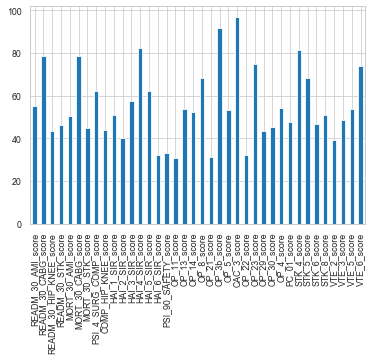

In [41]:
master_data_x = master_data_x.drop_duplicates(keep='first')
master_data_x
print_ln()

master_data_x.isnull().sum()

columns_with_missing_data = round(100 * (master_data_x.isnull().sum() / len(master_data_x.index)), 2)
columns_with_missing_data[columns_with_missing_data > 30].plot(kind='bar')
plt.show()

In [42]:

np.sum(master_data_x.isnull().sum().to_list())
print_ln()

master_data_x

-------------------------------------------------------------------------------- 



,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_CABG_score,...,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.615156,...,0.538880,-1.228236,-0.024906,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0.416331
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,NaN,...,0.324044,NaN,0.193305,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,NaN
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,-0.703937,...,0.538880,NaN,0.193305,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,0.416331
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,NaN,...,NaN,NaN,0.411517,-3.019716,NaN,0.333841,0.381176,NaN,NaN,NaN
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.489340,NaN,NaN,NaN,NaN
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,-0.843809,-0.526375,...,0.538880,-4.929290,NaN,-0.667976,-4.592380,-2.542886,-4.608052,-3.447662,0.635329,-3.876657
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,0.826243,NaN,...,-2.253994,NaN,NaN,-0.049098,0.618334,0.489340,0.214868,0.209952,0.635329,NaN
7,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,-0.843809,-1.236623,...,0.109207,NaN,0.193305,0.322230,0.435502,0.411590,0.381176,0.819555,0.368630,0.416331
8,10018,CALLAHAN EYE HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-7.207848,NaN,NaN,NaN,NaN
9,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,COLBERT,2563864556,NaN,NaN,...,-1.179812,NaN,-2.207021,-0.915528,-1.392818,0.178342,-0.450362,0.819555,0.635329,NaN


## Load the dependent variable i.e. the `rating` 

In [43]:
hospital_ratings = pd.read_csv("Hospital General Information.csv", encoding="ISO-8859-1", na_values=["Not Available", "Not Applicable"])
hospital_ratings.columns
print_ln()
print(hospital_ratings)
print_ln()

master_data_y = hospital_ratings

hospital_ratings[['Hospital overall rating']].isnull().sum()

master_data_y = master_data_y.iloc[:,[0, 12]]

-------------------------------------------------------------------------------- 

      Provider ID                           Hospital Name  \
0           10001        SOUTHEAST ALABAMA MEDICAL CENTER   
1           10005           MARSHALL MEDICAL CENTER SOUTH   
2           10006          ELIZA COFFEE MEMORIAL HOSPITAL   
3           10007                MIZELL MEMORIAL HOSPITAL   
4           10008             CRENSHAW COMMUNITY HOSPITAL   
...           ...                                     ...   
4813       480002  GOV JUAN F LUIS HOSPITAL & MEDICAL CTR   
4814       640001             LBJ TROPICAL MEDICAL CENTER   
4815       650001        GUAM MEMORIAL HOSPITAL AUTHORITY   
4816       650003              GUAM REGIONAL MEDICAL CITY   
4817       660001              COMMONWEALTH HEALTH CENTER   

                                    Address       City State  ZIP Code  \
0                    1108 ROSS CLARK CIRCLE     DOTHAN    AL     36301   
1                2505 U S HIGHWAY 43

In [44]:

print(master_data_y.columns)
print_ln()

master_data = pd.merge(master_data_x, master_data_y, on= "Provider ID")
print(master_data)
print_ln()

Index(['Provider ID', 'Hospital overall rating'], dtype='object')
-------------------------------------------------------------------------------- 

      Provider ID                     Hospital Name  \
0           10001  SOUTHEAST ALABAMA MEDICAL CENTER   
1           10005     MARSHALL MEDICAL CENTER SOUTH   
2           10006    ELIZA COFFEE MEMORIAL HOSPITAL   
3           10007          MIZELL MEMORIAL HOSPITAL   
4           10008       CRENSHAW COMMUNITY HOSPITAL   
...           ...                               ...   
4813       670112      CUMBERLAND SURGICAL HOSPITAL   
4814       640001       LBJ TROPICAL MEDICAL CENTER   
4815       650001  GUAM MEMORIAL HOSPITAL AUTHORITY   
4816       650003        GUAM REGIONAL MEDICAL CITY   
4817       660001        COMMONWEALTH HEALTH CENTER   

                            Address         City State  ZIP Code County Name  \
0            1108 ROSS CLARK CIRCLE       DOTHAN    AL     36301     HOUSTON   
1        2505 U S HIGHWAY 431 

In [45]:

master_data_without_na = master_data[master_data['Hospital overall rating'].notnull()]
master_data_without_na
print_ln()

print(master_data_without_na)

master_data_with_na = master_data[~master_data['Hospital overall rating'].notnull()]
print(master_data_with_na)
print_ln()

np.sum(master_data_without_na.isnull().sum().to_list())


-------------------------------------------------------------------------------- 

      Provider ID                                      Hospital Name  \
0           10001                   SOUTHEAST ALABAMA MEDICAL CENTER   
1           10005                      MARSHALL MEDICAL CENTER SOUTH   
2           10006                     ELIZA COFFEE MEMORIAL HOSPITAL   
3           10007                           MIZELL MEMORIAL HOSPITAL   
4           10008                        CRENSHAW COMMUNITY HOSPITAL   
...           ...                                                ...   
4795       670088  BAYLOR SCOTT & WHITE MEDICAL CENTER- COLLEGE S...   
4798       670092                         WALNUT HILL MEDICAL CENTER   
4802       670096              BAY AREA REGIONAL MEDICAL CENTER, LLC   
4804       670098                           RESOLUTE HEALTH HOSPITAL   
4815       650001                   GUAM MEMORIAL HOSPITAL AUTHORITY   

                            Address             City

65783

In [46]:
columns_with_missing_data = round(100 * (master_data_without_na.isnull().sum() / len(master_data_without_na.index)), 2)

output = columns_with_missing_data[columns_with_missing_data < 50]
output = list(output.to_dict().keys())
print_ln()

master_data_without_na = master_data_without_na[output]
master_data_without_na

-------------------------------------------------------------------------------- 



,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_COPD_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.866907,...,0.071075,NaN,0.538880,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,3.0
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,1.574551,...,0.500302,0.545870,0.324044,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,3.0
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,0.156930,...,0.328611,NaN,0.538880,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,2.0
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,NaN,0.078174,...,-3.448585,-1.232556,NaN,-3.019716,NaN,0.333841,0.381176,NaN,NaN,3.0
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,NaN,0.629471,...,0.714915,NaN,NaN,NaN,NaN,0.489340,NaN,NaN,NaN,3.0
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,-0.843809,0.314444,...,-1.688755,NaN,0.538880,-0.667976,-4.592380,-2.542886,-4.608052,-3.447662,0.635329,2.0
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,0.826243,0.629471,...,0.843683,0.723713,-2.253994,-0.049098,0.618334,0.489340,0.214868,0.209952,0.635329,3.0
7,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,-0.843809,1.653308,...,0.843683,NaN,0.109207,0.322230,0.435502,0.411590,0.381176,0.819555,0.368630,3.0
9,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,COLBERT,2563864556,NaN,-2.363284,...,0.843683,0.545870,-1.179812,-0.915528,-1.392818,0.178342,-0.450362,0.819555,0.635329,2.0
10,10021,DALE MEDICAL CENTER,126 HOSPITAL AVE,OZARK,AL,36360,DALE,3347742601,NaN,0.078174,...,0.414456,0.723713,NaN,NaN,NaN,0.567089,0.547483,NaN,NaN,4.0


In [47]:
# Impute only relevant numerical columns
master_data_without_na.iloc[ : , 8:] =  master_data_without_na.iloc[ : , 8:].apply(lambda x: x.fillna(x.median()), axis=0)

master_data_without_na

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,READM_30_AMI_score,READM_30_COPD_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0.408730,-0.866907,...,0.071075,0.368028,0.538880,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,3.0
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0.199974,1.574551,...,0.500302,0.545870,0.324044,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,3.0
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0.826243,0.156930,...,0.328611,0.368028,0.538880,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,2.0
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,0.095596,0.078174,...,-3.448585,-1.232556,0.324044,-3.019716,0.344086,0.333841,0.381176,0.331873,0.457530,3.0
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,0.095596,0.629471,...,0.714915,0.368028,0.324044,0.322230,0.344086,0.489340,0.381176,0.331873,0.457530,3.0
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,-0.843809,0.314444,...,-1.688755,0.368028,0.538880,-0.667976,-4.592380,-2.542886,-4.608052,-3.447662,0.635329,2.0
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,0.826243,0.629471,...,0.843683,0.723713,-2.253994,-0.049098,0.618334,0.489340,0.214868,0.209952,0.635329,3.0
7,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,-0.843809,1.653308,...,0.843683,0.368028,0.109207,0.322230,0.435502,0.411590,0.381176,0.819555,0.368630,3.0
9,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,COLBERT,2563864556,0.095596,-2.363284,...,0.843683,0.545870,-1.179812,-0.915528,-1.392818,0.178342,-0.450362,0.819555,0.635329,2.0
10,10021,DALE MEDICAL CENTER,126 HOSPITAL AVE,OZARK,AL,36360,DALE,3347742601,0.095596,0.078174,...,0.414456,0.723713,0.324044,0.322230,0.344086,0.567089,0.547483,0.331873,0.457530,4.0


In [48]:
master_data_without_na.isnull().sum()


Provider ID                0
Hospital Name              0
Address                    0
City                       0
State                      0
                          ..
VTE_1_score                0
VTE_2_score                0
VTE_3_score                0
VTE_5_score                0
Hospital overall rating    0
Length: 61, dtype: int64

In [49]:
master_data_without_na = master_data_without_na.drop(master_data_without_na.iloc[:, 1:8],  axis = 1)
master_data_without_na['Hospital overall rating'], factors_hospital_overall_rating =  pd.factorize(master_data_without_na['Hospital overall rating'])
cleaned_master_data = master_data_without_na

print_ln()
cleaned_master_data = cleaned_master_data.set_index('Provider ID')

print(cleaned_master_data)

cleaned_master_data.to_csv("cleaned_master_data_py.csv")

-------------------------------------------------------------------------------- 

             READM_30_AMI_score  READM_30_COPD_score  READM_30_HF_score  \
Provider ID                                                               
10001                  0.408730            -0.866907           0.370423   
10005                  0.199974             1.574551           0.036453   
10006                  0.826243             0.156930           0.904776   
10007                  0.095596             0.078174           0.570805   
10008                  0.095596             0.629471          -0.765075   
...                         ...                  ...                ...   
670088                -0.843809             0.550714           0.370423   
670092                -0.113161             0.156930          -0.431105   
670096                 0.513109             0.865741           1.038364   
670098                 0.095596             0.314444          -1.099046   
650001           

# EDA - TODO

In [50]:
hospital_ratings['Hospital Type'].value_counts()


Acute Care Hospitals         3382
Critical Access Hospitals    1337
Childrens                      99
Name: Hospital Type, dtype: int64

In [51]:
hospital_ratings =  hospital_ratings[hospital_ratings['Hospital Type'] == 'Acute Care Hospitals']

print(hospital_ratings)
print_ln()

hospital_ratings['Hospital Type'], factors_hospital_type =  pd.factorize(hospital_ratings['Hospital Type'])

print(hospital_ratings)



      Provider ID                           Hospital Name  \
0           10001        SOUTHEAST ALABAMA MEDICAL CENTER   
1           10005           MARSHALL MEDICAL CENTER SOUTH   
2           10006          ELIZA COFFEE MEMORIAL HOSPITAL   
3           10007                MIZELL MEMORIAL HOSPITAL   
4           10008             CRENSHAW COMMUNITY HOSPITAL   
...           ...                                     ...   
4813       480002  GOV JUAN F LUIS HOSPITAL & MEDICAL CTR   
4814       640001             LBJ TROPICAL MEDICAL CENTER   
4815       650001        GUAM MEMORIAL HOSPITAL AUTHORITY   
4816       650003              GUAM REGIONAL MEDICAL CITY   
4817       660001              COMMONWEALTH HEALTH CENTER   

                                    Address       City State  ZIP Code  \
0                    1108 ROSS CLARK CIRCLE     DOTHAN    AL     36301   
1                2505 U S HIGHWAY 431 NORTH       BOAZ    AL     35957   
2                        205 MARENGO STREET  

In [52]:

hospital_ratings['Hospital overall rating'].value_counts()



3.0    1426
4.0     749
2.0     659
1.0     117
5.0     110
Name: Hospital overall rating, dtype: int64

In [53]:
hospital_ratings = func_numeric(hospital_ratings,'Hospital overall rating')
hospital_ratings.dtypes

Provider ID                                                        int64
Hospital Name                                                     object
Address                                                           object
City                                                              object
State                                                             object
ZIP Code                                                           int64
County Name                                                       object
Phone Number                                                       int64
Hospital Type                                                      int64
Hospital Ownership                                                object
Emergency Services                                                object
Meets criteria for meaningful use of EHRs                         object
Hospital overall rating                                          float64
Hospital overall rating footnote                   

In [54]:

hospital_ratings['Hospital Ownership'].value_counts()

print_ln()

hospital_ratings = hospital_ratings[hospital_ratings['Hospital Ownership'].notnull()]
hospital_ratings


-------------------------------------------------------------------------------- 



,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Readmission national comparison,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote
0,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,HOUSTON,3347938701,0,Government - Hospital District or Authority,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Same as the National average,NaN
1,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,0,Government - Hospital District or Authority,...,Above the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Below the National average,NaN
2,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,LAUDERDALE,2567688400,0,Government - Hospital District or Authority,...,Same as the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN
3,10007,MIZELL MEMORIAL HOSPITAL,702 N MAIN ST,OPP,AL,36467,COVINGTON,3344933541,0,Voluntary non-profit - Private,...,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...
4,10008,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,3343353374,0,Proprietary,...,Same as the National average,NaN,NaN,Results are not available for this reporting p...,Same as the National average,NaN,Above the National average,NaN,NaN,Results are not available for this reporting p...
5,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,JEFFERSON,2058383122,0,Voluntary non-profit - Private,...,Same as the National average,NaN,Below the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Same as the National average,NaN
6,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,0,Proprietary,...,Same as the National average,NaN,Same as the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Same as the National average,NaN
7,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,SHELBY,2056208100,0,Voluntary non-profit - Private,...,Above the National average,NaN,Below the National average,NaN,Above the National average,NaN,Below the National average,NaN,Below the National average,NaN
8,10018,CALLAHAN EYE HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,0,Voluntary non-profit - Private,...,NaN,Results are not available for this reporting p...,NaN,Results are not available for this reporting p...,Below the National average,NaN,Same as the National average,NaN,NaN,Results are not available for this reporting p...
9,10019,HELEN KELLER MEMORIAL HOSPITAL,1300 SOUTH MONTGOMERY AVENUE,SHEFFIELD,AL,35660,COLBERT,2563864556,0,Government - Hospital District or Authority,...,Below the National average,NaN,Below the National average,NaN,Same as the National average,NaN,Above the National average,NaN,Below the National average,NaN


In [55]:
#hospital_ratings.dtypes
#print_ln()

hospital_ratings = func_numeric(hospital_ratings, 'Hospital overall rating')
#hospital_ratings.dtypes
hospital_ratings[['State', 'Hospital overall rating']]
print_ln()

avg_by_state = hospital_ratings.groupby(['State'])['Hospital overall rating'].agg({'Hospital overall rating': np.mean })

avg_by_state = avg_by_state.sort_values(by=['Hospital overall rating'], ascending= False).reset_index()
avg_by_state.head(10)

-------------------------------------------------------------------------------- 



,State,Hospital overall rating
0,SD,4.200000
1,WI,3.692308
2,DE,3.666667
3,ID,3.666667
4,IN,3.587500
5,MT,3.583333
6,NH,3.538462
7,KS,3.522727
8,MN,3.520833
9,CO,3.500000


-------------------------------------------------------------------------------- 



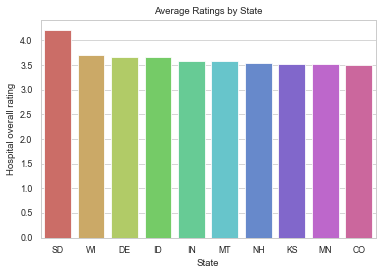

In [56]:
avg_by_state.head(10)
print_ln()

sns.barplot(x = 'State', y= "Hospital overall rating", data = avg_by_state.head(10), palette = 'hls')

plt.title("Average Ratings by State")
plt.show()

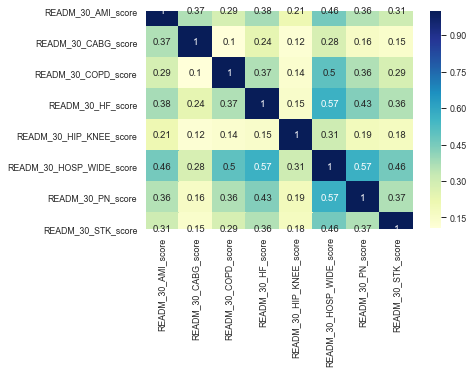

In [57]:
# correlation of readmission
readmission = read_master
readmission = readmission.drop(readmission.iloc[:, 0:8],  axis = 1)
readmission

corr_matrix = readmission.corr().abs()
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True)


In [58]:

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.40
high_corr_features = [column for column in upper.columns if any(upper[column] > 0.40)]

print("HIGHLY CORRELATED FEATURES IN DATA SET:{}\n\n{}".format(len(high_corr_features), high_corr_features))

HIGHLY CORRELATED FEATURES IN DATA SET:3

['READM_30_HOSP_WIDE_score', 'READM_30_PN_score', 'READM_30_STK_score']


## Model Building

In [59]:
# split into train and test
from sklearn.model_selection import train_test_split

#cleaned_master_data['Hospital overall rating'], factors_hospital_overall_rating =  pd.factorize(cleaned_master_data['Hospital overall rating'])

#cleaned_master_data = pd.get_dummies(cleaned_master_data['Hospital overall rating'], prefix='Hospital overall rating', drop_first=True)
print(cleaned_master_data)

print_ln()

X = cleaned_master_data.loc[:, cleaned_master_data.columns != 'Hospital overall rating']
y = cleaned_master_data.loc[:, 'Hospital overall rating']

#from sklearn import preprocessing
#y = preprocessing.label_binarize(y, classes=[ 1, 2, 3, 4, 5])


X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    train_size=0.7,
                                                    test_size=0.3, random_state=100)

X_train
print_ln()

X_test
print_ln()

y_train
print_ln()

y_test
print_ln()

             READM_30_AMI_score  READM_30_COPD_score  READM_30_HF_score  \
Provider ID                                                               
10001                  0.408730            -0.866907           0.370423   
10005                  0.199974             1.574551           0.036453   
10006                  0.826243             0.156930           0.904776   
10007                  0.095596             0.078174           0.570805   
10008                  0.095596             0.629471          -0.765075   
...                         ...                  ...                ...   
670088                -0.843809             0.550714           0.370423   
670092                -0.113161             0.156930          -0.431105   
670096                 0.513109             0.865741           1.038364   
670098                 0.095596             0.314444          -1.099046   
650001                -0.739430            -0.315610           0.504011   

             READM_30_HI

## Random Forest Modelling

In [60]:
## 100 estimators

In [61]:
from sklearn.ensemble import RandomForestClassifier

model_rf1= RandomForestClassifier(n_estimators= 100,                                   
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

#Train the model using the training sets y_pred=clf.predict(X_test)
model_rf1.fit(X_train, y_train)

y_pred= model_rf1.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


model_rf1_score = cross_val_score(model_rf1, X, y, cv=10)


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print_ln()

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print_ln()

print("=== All AUC Scores ===")
print(model_rf1_score)

print_ln()

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", model_rf1_score.mean())
print_ln()


# TODO
# https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

Accuracy: 0.6611872146118721
Mean Absolute Error: 0.5589041095890411
Mean Squared Error: 1.073972602739726
Root Mean Squared Error: 1.0363264942766475
=== Confusion Matrix ===
[[497  15  20   0   0]
 [122  82   1   0   0]
 [145   0 145   0   0]
 [  2   0  31   0   0]
 [  2  33   0   0   0]]
-------------------------------------------------------------------------------- 

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.65      0.93      0.76       532
           1       0.63      0.40      0.49       205
           2       0.74      0.50      0.60       290
           3       0.00      0.00      0.00        33
           4       0.00      0.00      0.00        35

    accuracy                           0.66      1095
   macro avg       0.40      0.37      0.37      1095
weighted avg       0.63      0.66      0.62      1095

-------------------------------------------------------------------------------- 

=== All AUC Scores ===


In [62]:
## 1000 estimators

In [63]:

from sklearn.ensemble import RandomForestClassifier

model_rf2= RandomForestClassifier(n_estimators= 1000,                                   
                                  random_state = 100,
                                  max_depth=5)

#Train the model using the training sets y_pred=clf.predict(X_test)
model_rf2.fit(X_train, y_train)

y_pred= model_rf2.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


model_rf2_score = cross_val_score(model_rf2, X, y, cv=10)


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print_ln()

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print_ln()

print("=== All AUC Scores ===")
print(model_rf2_score)

print_ln()

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", model_rf2_score.mean())
print_ln()


Accuracy: 0.6721461187214612
Mean Absolute Error: 0.5424657534246575
Mean Squared Error: 1.0484018264840183
Root Mean Squared Error: 1.0239149508059828
=== Confusion Matrix ===
[[503  11  18   0   0]
 [122  83   0   0   0]
 [142   0 148   0   0]
 [  1   0  30   2   0]
 [  3  32   0   0   0]]
-------------------------------------------------------------------------------- 

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.65      0.95      0.77       532
           1       0.66      0.40      0.50       205
           2       0.76      0.51      0.61       290
           3       1.00      0.06      0.11        33
           4       0.00      0.00      0.00        35

    accuracy                           0.67      1095
   macro avg       0.61      0.38      0.40      1095
weighted avg       0.67      0.67      0.63      1095

-------------------------------------------------------------------------------- 

=== All AUC Scores ===

In [64]:
## 1500 estimators
# https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74


In [65]:


from sklearn.ensemble import RandomForestClassifier

model_rf3= RandomForestClassifier(n_estimators= 1500)

#Train the model using the training sets y_pred=clf.predict(X_test)
model_rf3.fit(X_train, y_train)

y_pred= model_rf3.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix


model_rf3_score = cross_val_score(model_rf3, X, y, cv=10)


print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print_ln()

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print_ln()

print("=== All AUC Scores ===")
print(model_rf2_score)

print_ln()

print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", model_rf3_score.mean())
print_ln()



Accuracy: 0.7945205479452054
Mean Absolute Error: 0.3378995433789954
Mean Squared Error: 0.6520547945205479
Root Mean Squared Error: 0.8074990987738302
=== Confusion Matrix ===
[[509  10  13   0   0]
 [ 74 131   0   0   0]
 [ 78   0 212   0   0]
 [  0   0  23  10   0]
 [  0  27   0   0   8]]
-------------------------------------------------------------------------------- 

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.77      0.96      0.85       532
           1       0.78      0.64      0.70       205
           2       0.85      0.73      0.79       290
           3       1.00      0.30      0.47        33
           4       1.00      0.23      0.37        35

    accuracy                           0.79      1095
   macro avg       0.88      0.57      0.64      1095
weighted avg       0.81      0.79      0.78      1095

-------------------------------------------------------------------------------- 

=== All AUC Scores ===

## Feature weights assigned by Random Forest

In [70]:
import pandas as pd
feature_importances = pd.DataFrame(model_rf1.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
READM_30_HOSP_WIDE_score,0.118280
H_HSP_RATING_LINEAR_SCORE_score,0.107810
H_COMP_1_LINEAR_SCORE_score,0.093262
H_RECMND_LINEAR_SCORE_score,0.083364
PSI_90_SAFETY_score,0.078289
H_COMP_7_LINEAR_SCORE_score,0.065306
H_COMP_3_LINEAR_SCORE_score,0.058489
H_COMP_5_LINEAR_SCORE_score,0.055033
H_COMP_4_LINEAR_SCORE_score,0.043015
H_COMP_6_LINEAR_SCORE_score,0.033159


## Random forest weight analysis by Eli5

In [66]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model_rf1, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
eli5.show_weights(perm)

Weight,Feature
0.0456 ± 0.0076,x4
0.0319 ± 0.0071,x26
0.0256 ± 0.0054,x17
0.0244 ± 0.0063,x19
0.0178 ± 0.0053,x28
0.0160 ± 0.0057,x21
0.0139 ± 0.0047,x25
0.0123 ± 0.0045,x22
0.0114 ± 0.0051,x23
0.0109 ± 0.0035,x10


In [75]:
eli5.explain_weights(perm, feature_names= X_train.columns)

TypeError: Unexpected feature_names type

## PCA

In [1]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



## Group of measures

In [25]:
effe_master = pd.read_csv("effe_master_data_py.csv").drop(['Unnamed: 0'], axis= 1).set_index('Provider ID')
effe_master.info()

print_ln()

eff = effe_master.drop(effe_master.iloc[:, 0:7], axis=1)
eff.columns


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4818 entries, 10001 to 670112
Data columns (total 25 columns):
Hospital Name                   4818 non-null object
Address                         4818 non-null object
City                            4818 non-null object
State                           4818 non-null object
ZIP Code                        4818 non-null int64
County Name                     4803 non-null object
Phone Number                    4818 non-null int64
CAC_3_score                     146 non-null float64
IMM_2_score                     3779 non-null float64
IMM_3_OP_27_FAC_ADHPCT_score    4103 non-null float64
OP_22_score                     3270 non-null float64
OP_23_score                     1210 non-null float64
OP_29_score                     2731 non-null float64
OP_30_score                     2627 non-null float64
OP_4_score                      2216 non-null float64
PC_01_score                     2518 non-null float64
STK_4_score                     8

Index(['CAC_3_score', 'IMM_2_score', 'IMM_3_OP_27_FAC_ADHPCT_score',
       'OP_22_score', 'OP_23_score', 'OP_29_score', 'OP_30_score',
       'OP_4_score', 'PC_01_score', 'STK_4_score', 'STK_5_score',
       'STK_6_score', 'STK_8_score', 'VTE_1_score', 'VTE_2_score',
       'VTE_3_score', 'VTE_5_score', 'VTE_6_score'],
      dtype='object')

In [22]:

eff = effe_master.drop(effe_master.iloc[:, 0:7], axis=1)
eff.columns

Index(['CAC_3_score', 'IMM_2_score', 'IMM_3_OP_27_FAC_ADHPCT_score',
       'OP_22_score', 'OP_23_score', 'OP_29_score', 'OP_30_score',
       'OP_4_score', 'PC_01_score', 'STK_4_score', 'STK_5_score',
       'STK_6_score', 'STK_8_score', 'VTE_1_score', 'VTE_2_score',
       'VTE_3_score', 'VTE_5_score', 'VTE_6_score'],
      dtype='object')

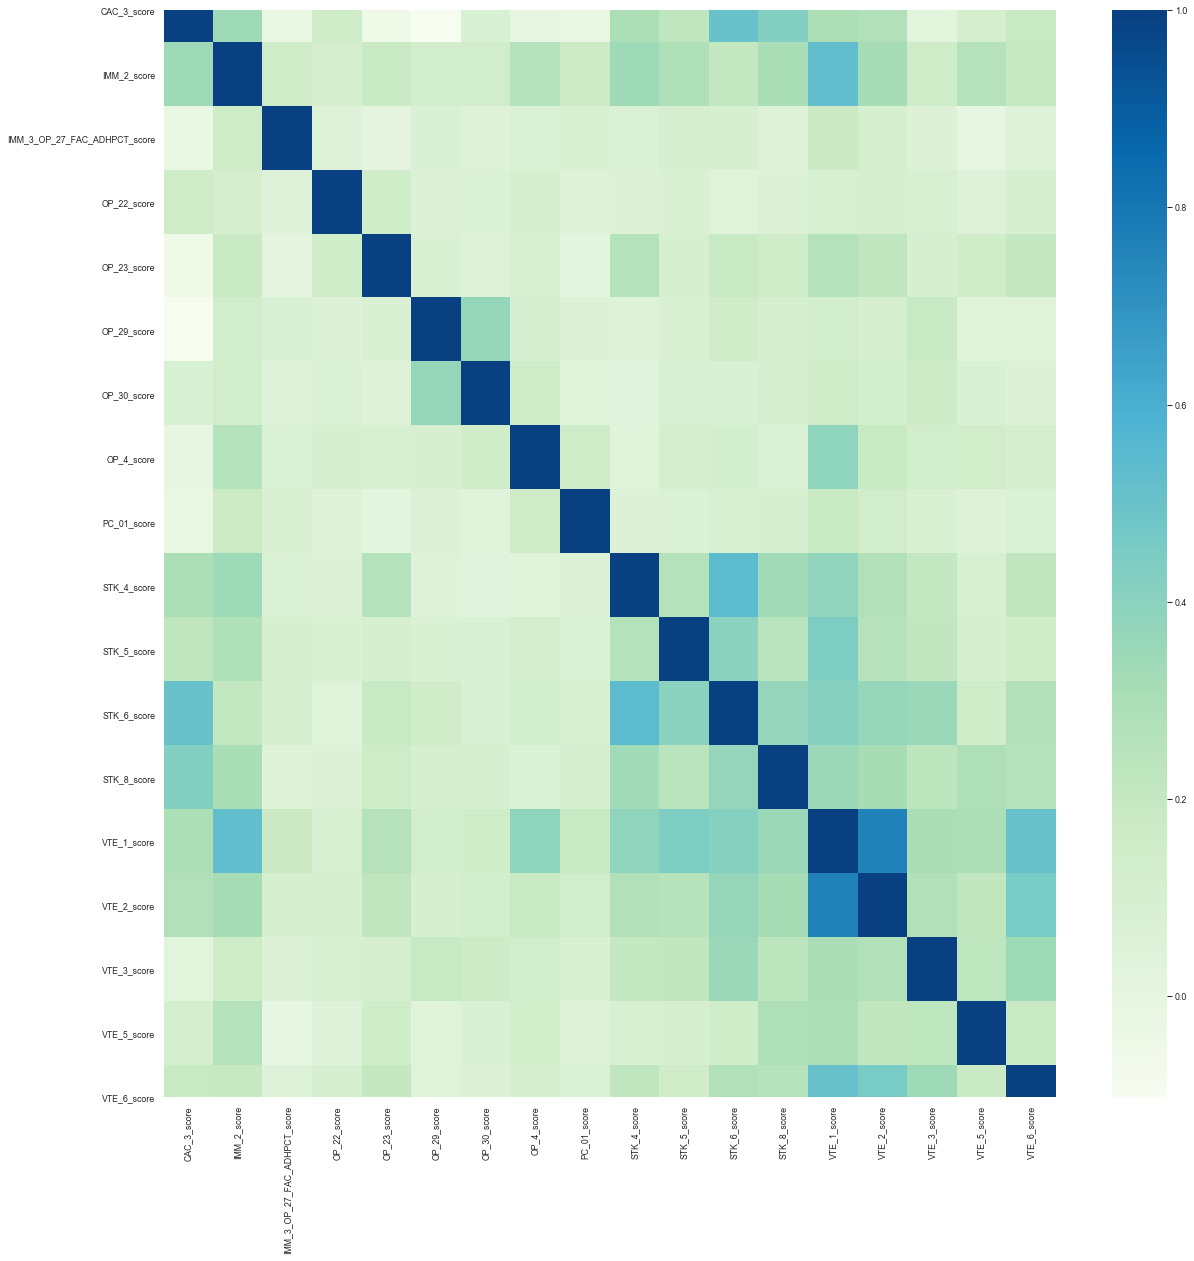

In [8]:


%matplotlib inline
plt.figure(figsize = (20,20))

sns.heatmap(eff.corr(), cmap='GnBu')

In [26]:
eff = eff.dropna(thresh= 3)

eff.to_csv("eff_data_py.csv")

eff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3739 entries, 10001 to 670106
Data columns (total 18 columns):
CAC_3_score                     126 non-null float64
IMM_2_score                     3641 non-null float64
IMM_3_OP_27_FAC_ADHPCT_score    3633 non-null float64
OP_22_score                     3243 non-null float64
OP_23_score                     1209 non-null float64
OP_29_score                     2731 non-null float64
OP_30_score                     2626 non-null float64
OP_4_score                      2080 non-null float64
PC_01_score                     2509 non-null float64
STK_4_score                     899 non-null float64
STK_5_score                     1540 non-null float64
STK_6_score                     2577 non-null float64
STK_8_score                     2361 non-null float64
VTE_1_score                     3551 non-null float64
VTE_2_score                     2926 non-null float64
VTE_3_score                     2482 non-null float64
VTE_5_score              

In [27]:
eff = eff.apply(lambda x: x.fillna(x.median()), axis=0)
eff

,CAC_3_score,IMM_2_score,IMM_3_OP_27_FAC_ADHPCT_score,OP_22_score,OP_23_score,OP_29_score,OP_30_score,OP_4_score,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
Provider ID,,,,,,,,,,,,,,,,,,
10001,0.214905,0.363857,-0.233117,-1.201473,0.179361,0.367430,0.071075,0.368028,0.538880,-1.228236,-0.024906,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0.416331
10005,0.214905,0.530272,-0.099026,-0.108314,0.783472,0.692171,0.500302,0.545870,0.324044,0.318473,0.193305,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,0.416331
10006,0.214905,0.613480,0.169157,0.438265,0.179361,-0.101641,0.328611,0.368028,0.538880,0.318473,0.193305,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,0.416331
10007,0.214905,0.530272,-2.110397,0.438265,0.179361,-2.627406,-3.448585,-1.232556,0.324044,0.318473,0.411517,-3.019716,0.344086,0.333841,0.381176,0.331873,0.457530,0.416331
10008,0.214905,0.197442,-2.780853,0.438265,0.179361,0.836500,0.714915,0.368028,0.324044,0.318473,0.411517,0.322230,0.344086,0.489340,0.381176,0.331873,0.457530,0.416331
10011,0.214905,-0.801048,-2.110397,-0.654894,-3.545988,0.150936,-1.688755,0.368028,0.538880,-4.929290,0.411517,-0.667976,-4.592380,-2.542886,-4.608052,-3.447662,0.635329,-3.876657
10012,0.214905,0.613480,0.370294,-0.108314,0.280046,0.980830,0.843683,0.723713,-2.253994,0.318473,0.411517,-0.049098,0.618334,0.489340,0.214868,0.209952,0.635329,0.416331
10016,0.214905,0.447065,-0.568346,-0.108314,0.179361,0.547841,0.843683,0.368028,0.109207,0.318473,0.193305,0.322230,0.435502,0.411590,0.381176,0.819555,0.368630,0.416331
10018,0.214905,-4.462180,-1.305848,0.984844,0.179361,0.367430,0.414456,0.368028,0.324044,0.318473,0.411517,0.322230,0.344086,-7.207848,0.381176,0.331873,0.457530,0.416331


In [28]:

## With Incremental PCA

from sklearn.decomposition import IncrementalPCA, PCA
pca = IncrementalPCA()
eff_pca = pca.fit_transform(eff)
eff_pca = pd.DataFrame(eff_pca, columns=eff.columns)
eff_pca.index = eff.index
eff_pca


,CAC_3_score,IMM_2_score,IMM_3_OP_27_FAC_ADHPCT_score,OP_22_score,OP_23_score,OP_29_score,OP_30_score,OP_4_score,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
Provider ID,,,,,,,,,,,,,,,,,,
10001,-0.180572,-0.607867,0.232818,-0.803696,-1.135688,-0.417882,0.405073,0.610692,-0.023666,0.094456,-0.056203,-0.382423,-0.178485,-0.295547,-0.951391,0.427680,0.986205,0.043967
10005,0.401928,0.447193,0.248439,-0.609422,0.168175,1.237431,-0.021647,0.393217,0.402495,0.114624,0.112884,0.652379,0.017990,0.709158,-0.050015,0.231321,-0.037481,0.017220
10006,-0.251522,-0.789182,0.631346,-0.555298,0.568469,-0.032184,-0.973734,0.355299,-0.030700,-0.647529,0.354895,-0.500252,0.443655,0.319710,0.162679,-0.283218,0.333688,0.003018
10007,-2.137142,-2.654506,-3.416023,-0.054714,2.107179,1.477375,0.817468,0.189865,0.058911,1.500646,-1.514176,1.126527,0.279476,0.217848,0.272794,0.728082,-0.322195,-0.024118
10008,0.292337,1.365921,-1.585151,-2.154003,0.311725,-0.424090,-0.016704,0.124668,0.084082,0.162811,-0.000749,-0.050615,0.223894,-0.058710,0.041347,-0.023225,0.023259,-0.010291
10011,-7.346154,-1.643492,1.666418,-2.322151,0.682709,-0.433134,-1.886539,1.993465,1.991890,-0.436584,1.534259,-3.547446,0.938734,-4.799636,-3.036992,2.465804,-0.337203,0.169791
10012,0.894629,0.319966,0.611553,-0.537562,-0.495990,0.630663,-0.063223,-2.123720,0.664617,0.262883,0.923817,0.449549,-0.334612,-0.040027,0.129645,0.115956,0.036467,-0.012850
10016,0.862069,0.700704,-0.299850,-0.712329,-0.345928,0.195920,0.147987,-0.032019,0.182507,-0.215953,-0.158343,0.221248,-0.032695,0.002959,-0.072643,-0.118570,0.024445,0.007596
10018,-5.077776,5.563602,-0.535745,2.837922,0.575312,-1.104549,-0.010870,0.742790,-0.895718,0.134565,0.663483,0.172213,-2.662754,-0.276647,0.522760,0.496817,-0.074199,0.067516


In [29]:
pca.explained_variance_ratio_

array([0.16346639, 0.10704536, 0.08895391, 0.07967539, 0.07136638,
       0.06168113, 0.05517529, 0.0515865 , 0.04968937, 0.04710474,
       0.04481184, 0.03988629, 0.03555335, 0.0322619 , 0.02610687,
       0.02154447, 0.02027522, 0.00381559])

In [30]:
eff_pca_weights = pd.DataFrame(pca.components_, columns=eff.columns)
eff_pca_weights


,CAC_3_score,IMM_2_score,IMM_3_OP_27_FAC_ADHPCT_score,OP_22_score,OP_23_score,OP_29_score,OP_30_score,OP_4_score,PC_01_score,STK_4_score,STK_5_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,VTE_6_score
0,0.013112,0.407054,0.254310,0.186861,0.067392,0.200449,0.186468,0.149609,0.109179,0.071309,0.111184,0.283824,0.240842,0.493763,0.350765,0.247209,0.169015,0.090697
1,-0.004115,-0.382797,-0.262350,0.176968,0.038425,0.428204,0.455362,-0.051015,0.021705,0.020547,0.026775,0.143951,0.168603,-0.395197,0.028418,0.318909,0.210064,0.070253
2,-0.018033,-0.009293,0.647264,0.023588,-0.042580,0.437171,0.342969,0.042725,-0.017079,-0.063245,-0.083932,-0.222000,-0.268611,-0.045030,-0.187193,-0.151376,-0.262763,-0.076785
3,0.001057,-0.333627,0.647207,0.128411,0.001756,-0.296159,-0.314917,-0.133874,0.012670,0.022469,0.037996,0.245041,0.188510,-0.283089,0.063694,0.210104,0.139948,0.053870
4,-0.004422,0.054654,-0.068666,0.893894,0.035746,-0.127695,-0.077942,0.055277,0.094972,0.008578,-0.043437,-0.342309,-0.135674,-0.006189,-0.067306,-0.053983,0.094934,0.058826
5,-0.001122,0.267776,0.131484,-0.259661,-0.026408,-0.103097,0.128966,-0.106737,-0.022749,0.030288,-0.094649,-0.515557,0.160003,-0.065693,-0.247379,0.173721,0.630273,0.097479
6,-0.030664,-0.428617,0.013629,-0.149264,0.021344,-0.138207,0.062163,0.187924,-0.021030,-0.034676,-0.133300,-0.325702,-0.422802,0.256721,0.510088,0.292867,0.064978,0.117474
7,-0.010402,-0.012318,-0.020444,-0.129297,-0.048711,0.104904,-0.189373,0.266743,0.905326,-0.035466,-0.051174,-0.021443,-0.035481,-0.084948,-0.128231,0.111711,-0.012444,-0.026601
8,-0.013118,0.124171,-0.050847,0.020218,-0.001396,0.249918,-0.391724,0.210931,-0.304498,-0.011297,0.011921,0.135616,-0.329499,0.043877,-0.395567,0.583667,0.004105,-0.044523
9,-0.001217,-0.074190,-0.016856,-0.015560,0.049420,0.609732,-0.564202,-0.246609,-0.045094,-0.002115,-0.070071,-0.223414,0.150039,0.029113,0.299901,-0.217952,0.145550,0.041992


In [37]:
eff_measure_weight = eff_pca.mean(axis=1)
eff_scores = pd.DataFrame({'effe' : eff_measure_weight})
eff_scores

,effe
Provider ID,
10001,-0.124029
10005,0.246438
10006,-0.049492
10007,-0.074817
10008,-0.094083
10011,-0.797015
10012,0.079542
10016,0.019839
10018,0.063262


In [40]:

eff_scores.to_csv("eff_scores_data_py.csv")

eff_scores

,effe
Provider ID,
10001,-0.124029
10005,0.246438
10006,-0.049492
10007,-0.074817
10008,-0.094083
10011,-0.797015
10012,0.079542
10016,0.019839
10018,0.063262


## Entire dataset - all features together

In [138]:
cleaned_master_data = pd.read_csv("cleaned_master_data_py.csv")
cleaned_master_data.head()

,Provider ID,READM_30_AMI_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score,MORT_30_AMI_score,MORT_30_COPD_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
0,10001,0.408730,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569,1.249515,-1.094132,...,0.071075,0.368028,0.538880,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0
1,10005,0.199974,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118,-1.546065,0.434008,...,0.500302,0.545870,0.324044,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,0
2,10006,0.826243,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980,-2.105181,0.883461,...,0.328611,0.368028,0.538880,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,1
3,10007,0.095596,0.078174,0.570805,0.019388,-1.237171,-0.130886,-0.124569,0.051410,-1.094132,...,-3.448585,-1.232556,0.324044,-3.019716,0.344086,0.333841,0.381176,0.331873,0.457530,0
4,10008,0.095596,0.629471,-0.765075,0.019388,-0.147737,0.774096,0.061873,0.051410,-0.105335,...,0.714915,0.368028,0.324044,0.322230,0.344086,0.489340,0.381176,0.331873,0.457530,0


In [139]:
cleaned_master_data.columns

Index(['Provider ID', 'READM_30_AMI_score', 'READM_30_COPD_score',
       'READM_30_HF_score', 'READM_30_HIP_KNEE_score',
       'READM_30_HOSP_WIDE_score', 'READM_30_PN_score', 'READM_30_STK_score',
       'MORT_30_AMI_score', 'MORT_30_COPD_score', 'MORT_30_HF_score',
       'MORT_30_PN_score', 'MORT_30_STK_score', 'COMP_HIP_KNEE_score',
       'HAI_1_SIR_score', 'HAI_2_SIR_score', 'HAI_3_SIR_score',
       'HAI_6_SIR_score', 'PSI_90_SAFETY_score', 'H_CLEAN_LINEAR_SCORE_score',
       'H_COMP_1_LINEAR_SCORE_score', 'H_COMP_2_LINEAR_SCORE_score',
       'H_COMP_3_LINEAR_SCORE_score', 'H_COMP_4_LINEAR_SCORE_score',
       'H_COMP_5_LINEAR_SCORE_score', 'H_COMP_6_LINEAR_SCORE_score',
       'H_COMP_7_LINEAR_SCORE_score', 'H_HSP_RATING_LINEAR_SCORE_score',
       'H_QUIET_LINEAR_SCORE_score', 'H_RECMND_LINEAR_SCORE_score',
       'OP_10_score', 'OP_11_score', 'OP_13_score', 'OP_14_score',
       'ED_1b_score', 'ED_2b_score', 'OP_18b_score', 'OP_20_score',
       'OP_21_score', 'OP_5_score

In [140]:
cleaned_master_data.shape

(3648, 54)

In [141]:
cleaned_master_data.describe(percentiles=[.25,.5,.75,.90,.95,.99])


,Provider ID,READM_30_AMI_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score,MORT_30_AMI_score,MORT_30_COPD_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
count,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,...,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000
mean,264497.236294,0.040316,0.011140,0.004741,0.006706,-0.000939,-0.013489,0.020016,0.018961,0.004194,...,0.128376,0.186334,0.123164,0.107794,0.138350,0.108543,0.099985,0.113131,0.187199,0.935581
std,157276.680884,0.755860,0.965464,0.968790,0.835301,1.030625,1.000049,0.828295,0.794316,0.966671,...,0.848641,0.699205,0.706634,0.809407,0.745856,0.751082,0.790766,0.808478,0.785138,1.075420
min,10001.000000,-3.453265,-4.017174,-3.303249,-3.775556,-3.900231,-3.750815,-3.853419,-3.622782,-3.970632,...,-3.448585,-5.856466,-7.624905,-7.351867,-8.066189,-7.207848,-7.767896,-5.276469,-6.121062,0.000000
25%,140014.500000,-0.113161,-0.551880,-0.564693,-0.342035,-0.631929,-0.618184,-0.217790,-0.268085,-0.464898,...,0.028152,0.190185,0.109207,0.198454,0.161254,0.022843,0.048561,0.088032,0.279730,0.000000
50%,260018.500000,0.095596,0.078174,0.036453,0.019388,0.094360,0.077956,0.061873,0.051410,0.074446,...,0.414456,0.368028,0.324044,0.322230,0.344086,0.333841,0.381176,0.331873,0.457530,1.000000
75%,390113.250000,0.199974,0.629471,0.637599,0.380811,0.608815,0.634868,0.434758,0.291031,0.613789,...,0.629070,0.368028,0.538880,0.446005,0.435502,0.489340,0.547483,0.575714,0.635329,2.000000
90%,460054.900000,0.826243,1.180768,1.171952,0.922946,1.183794,1.191780,0.994086,1.009894,1.153133,...,0.843683,0.723713,0.538880,0.569781,0.618334,0.567089,0.547483,0.819555,0.635329,2.000000
95%,510056.950000,1.348135,1.574551,1.572716,1.465081,1.546938,1.470236,1.273750,1.329389,1.422805,...,0.843683,0.723713,0.538880,0.569781,0.618334,0.567089,0.547483,0.819555,0.635329,3.000000
99%,594217.640000,2.183161,2.204605,2.240656,2.007216,2.394276,2.064044,1.926299,2.048253,2.052039,...,0.843683,0.723713,0.538880,0.569781,0.618334,0.567089,0.547483,0.819555,0.635329,4.000000


In [142]:

cleaned_master_data_numerical_values = cleaned_master_data.drop(['Provider ID'], axis=1)
cleaned_master_data_numerical_values.head()



,READM_30_AMI_score,READM_30_COPD_score,READM_30_HF_score,READM_30_HIP_KNEE_score,READM_30_HOSP_WIDE_score,READM_30_PN_score,READM_30_STK_score,MORT_30_AMI_score,MORT_30_COPD_score,MORT_30_HF_score,...,OP_30_score,OP_4_score,PC_01_score,STK_6_score,STK_8_score,VTE_1_score,VTE_2_score,VTE_3_score,VTE_5_score,Hospital overall rating
0,0.408730,-0.866907,0.370423,-0.884170,0.215408,-1.105482,-0.124569,1.249515,-1.094132,-0.165556,...,0.071075,0.368028,0.538880,0.446005,-0.570074,0.333841,0.381176,-0.277730,-0.253670,0
1,0.199974,1.574551,0.036453,-1.968440,0.820649,0.495640,-0.777118,-1.546065,0.434008,-2.286446,...,0.500302,0.545870,0.324044,-0.915528,0.618334,0.178342,-0.450362,0.819555,0.635329,0
2,0.826243,0.156930,0.904776,-0.703459,0.215408,-0.548570,0.527980,-2.105181,0.883461,-2.354862,...,0.328611,0.368028,0.538880,0.198454,-0.295826,0.411590,-1.281900,-0.887332,-0.075870,1
3,0.095596,0.078174,0.570805,0.019388,-1.237171,-0.130886,-0.124569,0.051410,-1.094132,-1.533872,...,-3.448585,-1.232556,0.324044,-3.019716,0.344086,0.333841,0.381176,0.331873,0.457530,0
4,0.095596,0.629471,-0.765075,0.019388,-0.147737,0.774096,0.061873,0.051410,-0.105335,-0.370803,...,0.714915,0.368028,0.324044,0.322230,0.344086,0.489340,0.381176,0.331873,0.457530,0


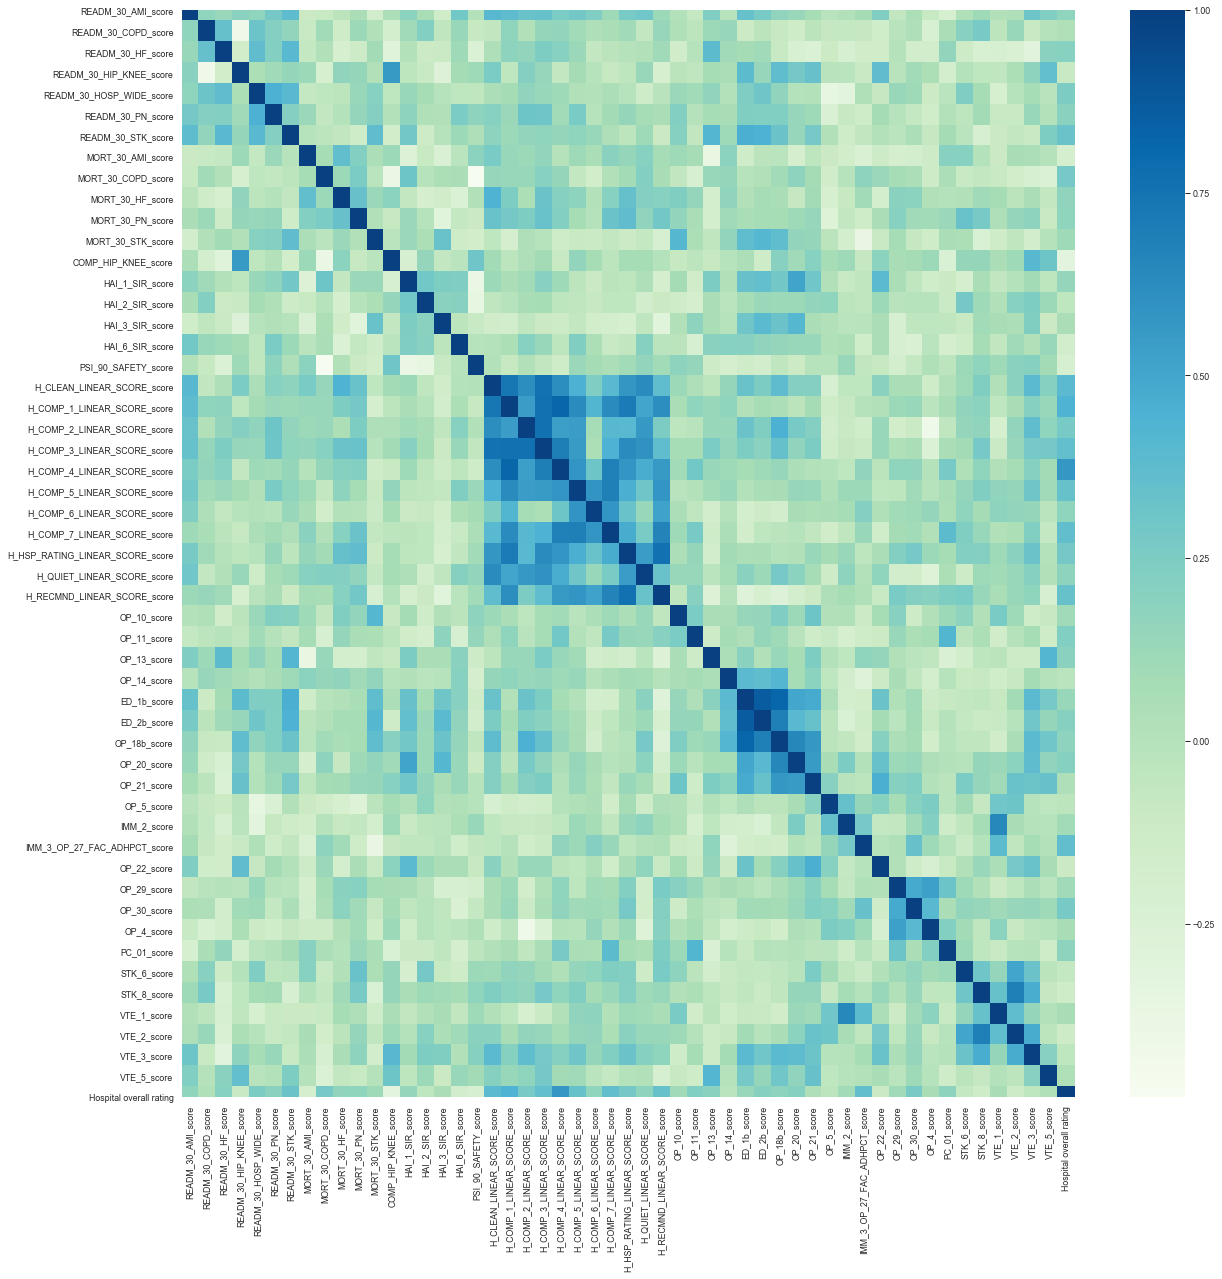

In [372]:

%matplotlib inline
plt.figure(figsize = (20,20))

corr_matrix = cleaned_master_data_numerical_values.head(50).corr()

sns.heatmap(corr_matrix, \
            cmap='GnBu', \
            xticklabels=cleaned_master_data_numerical_values.columns, \
            yticklabels=cleaned_master_data_numerical_values.columns)

In [335]:

# Putting feature variable to X
X = cleaned_master_data_numerical_values.drop(['Hospital overall rating'],axis=1)
#X = pd.DataFrame(StandardScaler().fit_transform(X))

# Putting response variable to y
y = cleaned_master_data_numerical_values['Hospital overall rating']


In [340]:

## With Incremental PCA

from sklearn.decomposition import IncrementalPCA
X_pca = IncrementalPCA(n_components= 3).fit_transform(X)
X_pca



array([[-1.6802784 , -1.89916634, -1.97610882],
       [ 0.85537185,  1.61525184, -0.15648504],
       [-0.60843469,  2.27278698,  0.64404751],
       ...,
       [-0.96007821,  1.24953128,  1.87201552],
       [ 0.44718557,  0.47851705,  0.63662694],
       [ 0.60644028,  1.02040394,  0.08502457]])

In [359]:

pc = np.transpose(X_pca)

pc_df = pd.DataFrame({'PC1':pc[0],'PC2':pc[1], 'PC3':pc[2]})
pc_df.head(10)

,PC1,PC2,PC3
0,-1.680278,-1.899166,-1.976109
1,0.855372,1.615252,-0.156485
2,-0.608435,2.272787,0.644048
3,0.789615,3.118021,-2.223569
4,0.810238,1.117464,0.921205
5,-2.282076,0.689149,-0.305757
6,0.362765,1.784711,-0.407106
7,-1.029601,-0.652066,0.505874
8,-0.533559,2.420541,-1.181640
9,2.798830,0.801426,0.635913


In [360]:
pc_df.index = y.index
pc_df.head()
pc_df = pd.concat([pc_df, y], axis=1)
pc_df.head(10)

,PC1,PC2,PC3,Hospital overall rating
0,-1.680278,-1.899166,-1.976109,0
1,0.855372,1.615252,-0.156485,0
2,-0.608435,2.272787,0.644048,1
3,0.789615,3.118021,-2.223569,0
4,0.810238,1.117464,0.921205,0
5,-2.282076,0.689149,-0.305757,1
6,0.362765,1.784711,-0.407106,0
7,-1.029601,-0.652066,0.505874,0
8,-0.533559,2.420541,-1.181640,1
9,2.798830,0.801426,0.635913,2


In [381]:
pc_df['Hospital overall rating'].value_counts()

0    1772
2     964
1     684
4     117
3     111
Name: Hospital overall rating, dtype: int64

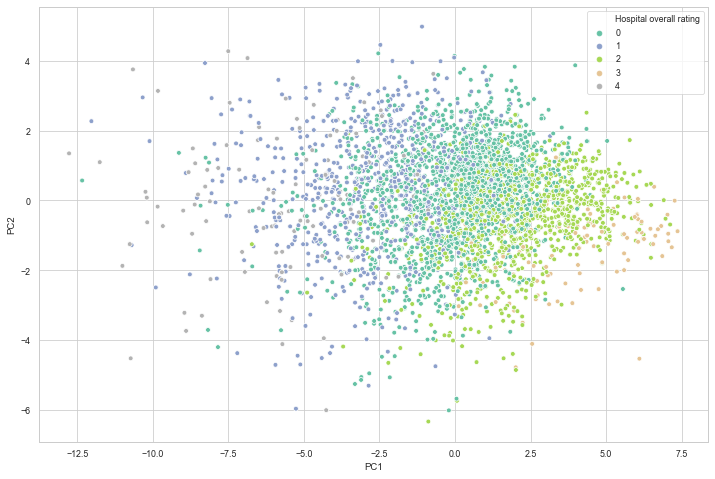

In [365]:
fig = plt.figure(figsize = (12,8))

sns.scatterplot(x='PC1',y='PC2',hue='Hospital overall rating',legend='full',data= pc_df, palette='Set2')

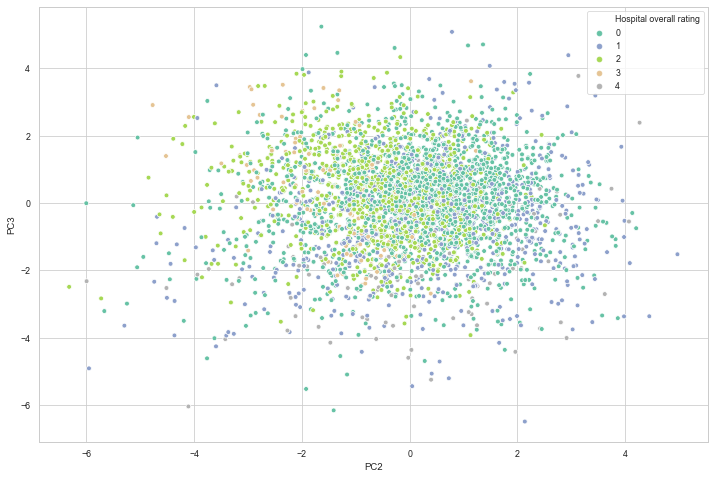

In [383]:
fig = plt.figure(figsize = (12,8))

sns.scatterplot(x='PC2',y='PC3',hue='Hospital overall rating',legend='full',data= pc_df, palette='Set2')

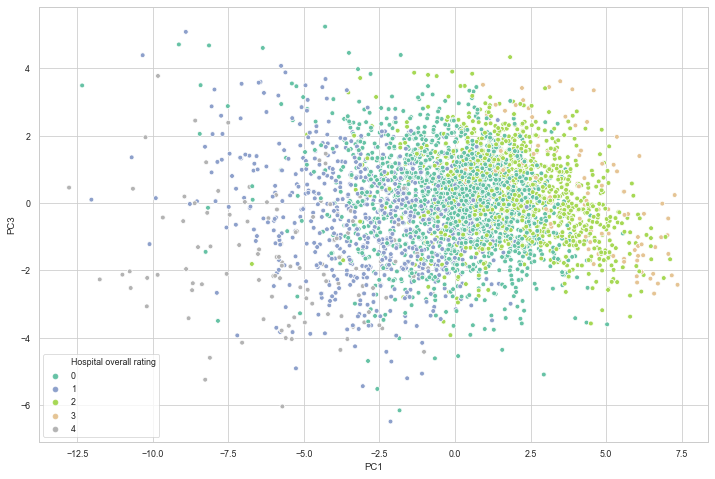

In [384]:
fig = plt.figure(figsize = (12,8))

sns.scatterplot(x='PC1',y='PC3',hue='Hospital overall rating',legend='full',data= pc_df, palette='Set2')

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X_pca ,y, \
                                                    train_size=0.7, \
                                                    test_size=0.3, \
                                                    random_state=100)


## Clustering via K-means

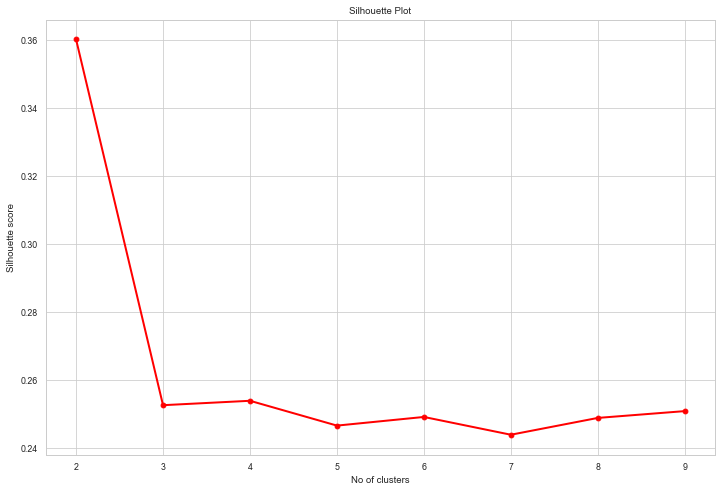

In [373]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(X_test)
    sse_.append([k, silhouette_score(X_test, kmeans.labels_)])

    
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1], 'ro-', linewidth=2);
plt.title('Silhouette Plot')
plt.xlabel('No of clusters')
plt.ylabel('Silhouette score')
plt.show()

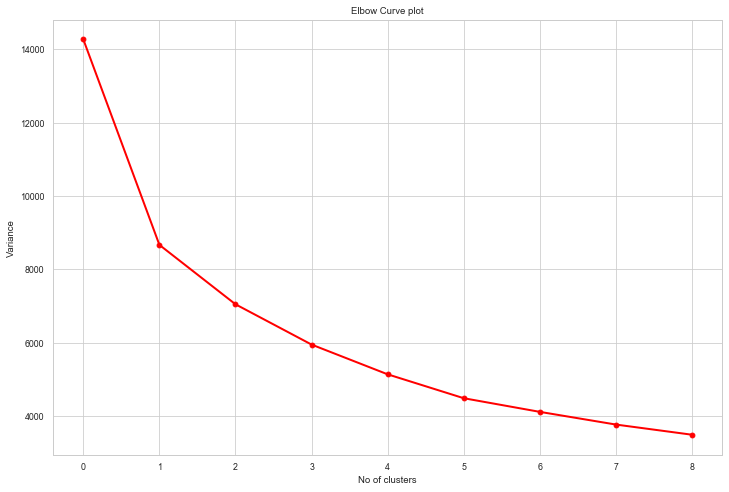

In [375]:

# Elbow curve method

ssd = []
for num_clusters in list(range(1,10)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(X_test)
    ssd.append(model_clus.inertia_)

fig = plt.figure(figsize = (12,8))
plt.plot(ssd, 'ro-', linewidth=2);
plt.title('Elbow Curve plot')
plt.xlabel('No of clusters')
plt.ylabel('Variance')
plt.show()

In [376]:
kmeans_model = KMeans(n_clusters = 3, max_iter=100, random_state = 100)
kmeans_model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=100, tol=0.0001, verbose=0)

In [377]:

y_pred= kmeans_model.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5972602739726027


In [380]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print_ln()

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print_ln()

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print_ln()

kmeans_model_score = cross_val_score(kmeans_model, X, y, cv=10)


print("=== All AUC Scores ===")
print(kmeans_model_score)
print_ln()


print("=== Mean AUC Score ===")
print("Mean AUC Score - K-means: ", kmeans_model_score.mean())
print_ln()


Mean Absolute Error: 0.6712328767123288
Mean Squared Error: 1.2812785388127854
Root Mean Squared Error: 1.1319357485355719
-------------------------------------------------------------------------------- 

=== Confusion Matrix ===
[[359  63 107   0   0]
 [ 85 149   2   0   0]
 [110  10 146   0   0]
 [  6   0  26   0   0]
 [  1  31   0   0   0]]
-------------------------------------------------------------------------------- 

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.64      0.68      0.66       529
           1       0.59      0.63      0.61       236
           2       0.52      0.55      0.53       266
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        32

    accuracy                           0.60      1095
   macro avg       0.35      0.37      0.36      1095
weighted avg       0.56      0.60      0.58      1095

---------------------------------------------------

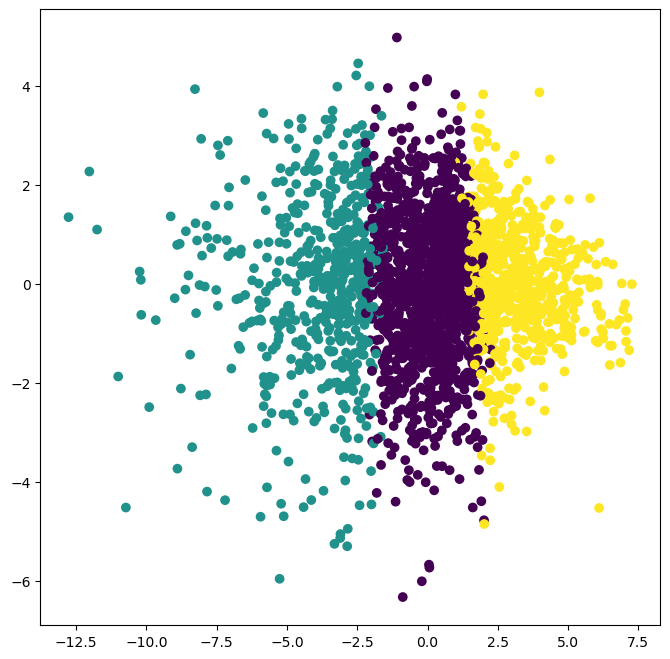

In [425]:

plt.figure(figsize=(8, 8))
plt.scatter(X_train[:,0],X_train[:,1], label='True Position', c=kmeans_model.labels_, cmap= 'viridis')
#plt.title('Customer Spend Local vs Organic - Weighted K-Means',fontsize=18, fontweight='bold')
#plt.xlabel('Pct_Spend_in_Local',fontsize=15)
#plt.ylabel('Pct_Spend_in_Organic',fontsize=15)


## K-means Eli5

In [430]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(kmeans_model, cv = None, refit = False, n_iter = 50).fit(X_train, y_train)
eli5.show_weights(perm)

Weight,Feature
242.7248 ± 53.0224,x0
232.7781 ± 88.9053,x2
7.8803 ± 16.7595,x1
